In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler


In [78]:
df = pd.read_csv("customers_all_processed_wo_email.csv")
opt_df = df.fillna(0)



In [79]:
#opt_df["IS_ENGAGED_CUST"] = np.where((opt_df['ORDERER_PHY_CARD'] == 1) | ((opt_df["TRN_COUNT"] > 0) & (opt_df['CUST_LAST_LOGIN_DAYS'] <= 15) & (opt_df['TRN_CNT_LST_YEAR'] > 20) & (opt_df['AVG_TRN_AMT'] > 25)), 1,0)
opt_df = opt_df.loc[:,'CUST_LAST_LOGIN_DAYS':'IS_ENGAGED_CUST']
opt_df

,CUST_LAST_LOGIN_DAYS,TRN_COUNT,TRN_CNT_LST_YEAR,AVG_TRN_AMT,DAYS_AFTER_LAST_TRN,DAYS_BTW_REG_AND_LAST_TRN,ORDERER_PHY_CARD,HAS_RECUR_TRN,IS_ENGAGED_CUST
0,6,12,12,5,6,0,0,0,1
1,1000,6,6,8,10,0,0,0,1
2,1000,4,4,3,10,0,0,0,1
3,1000,6,6,5,10,0,0,0,1
4,1000,9,9,3,10,0,0,0,1
...,...,...,...,...,...,...,...,...,...
6749201,1000,0,0,0,0,0,0,0,0
6749202,1000,0,0,0,0,0,0,0,0
6749203,1000,0,0,0,0,0,0,0,0
6749204,1000,0,0,0,0,0,0,0,0


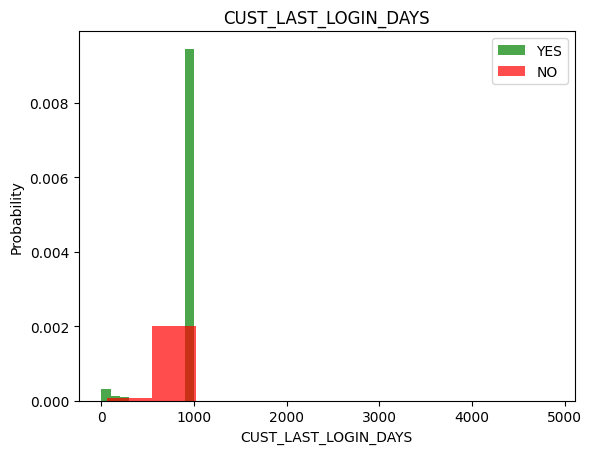

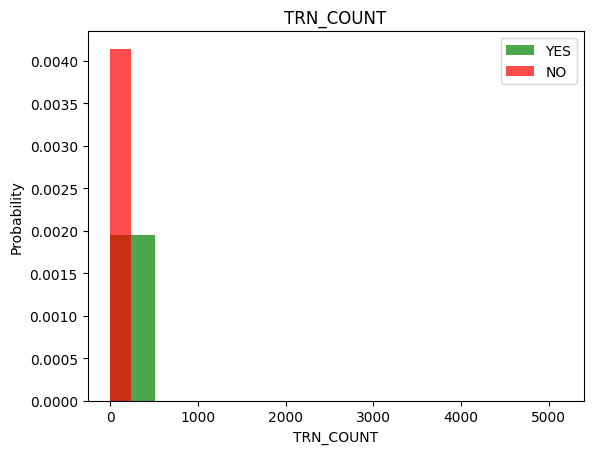

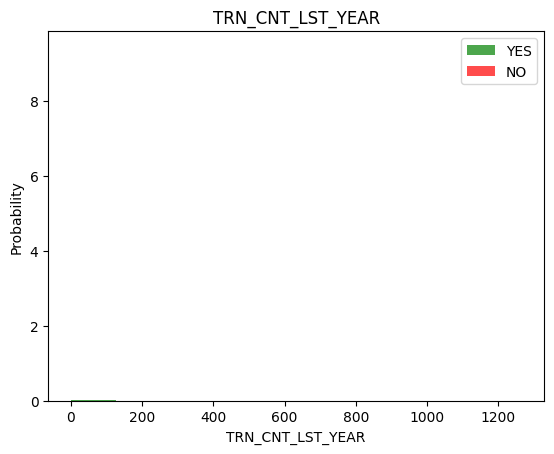

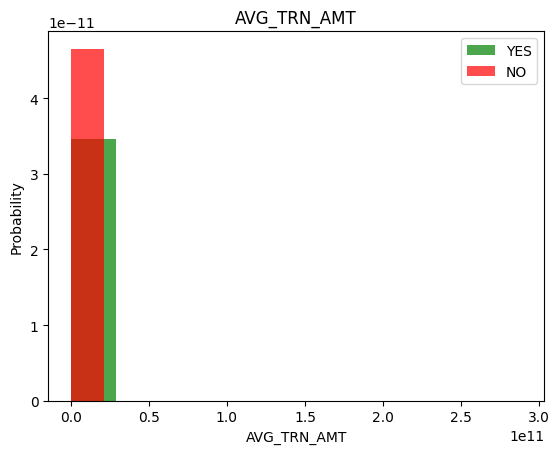

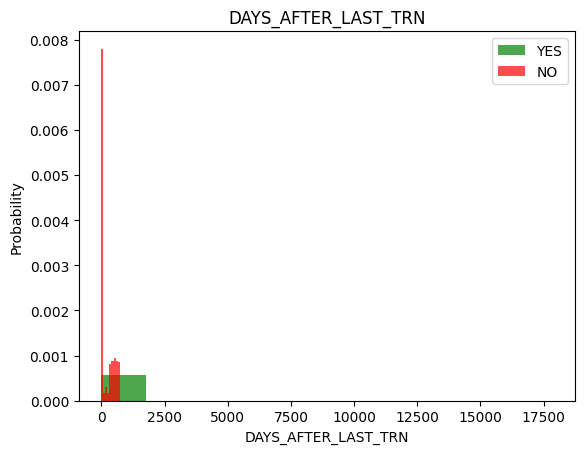

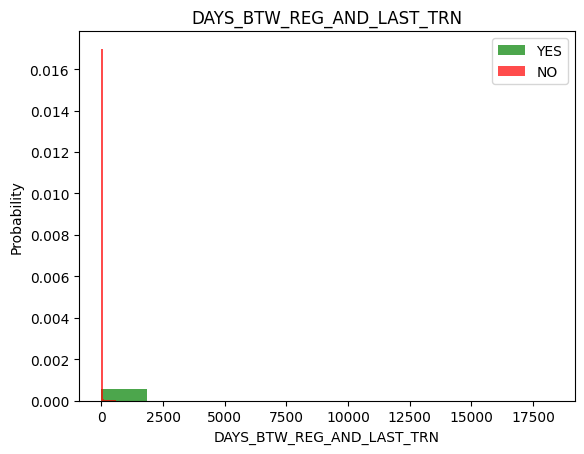

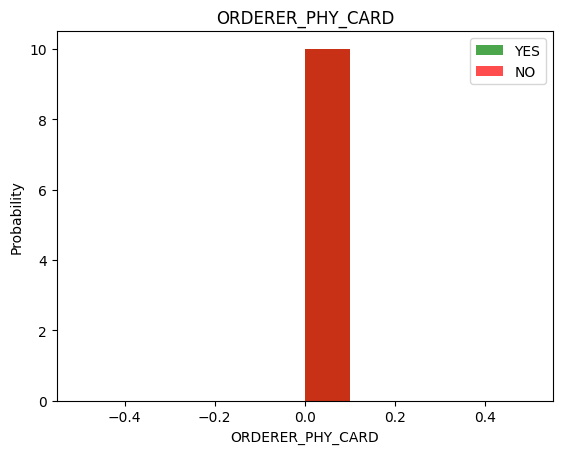

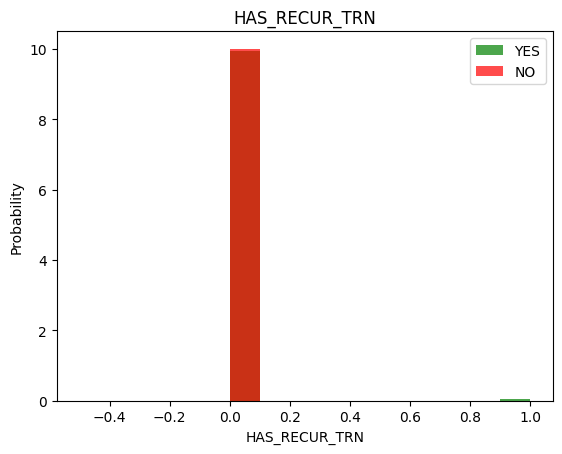

In [80]:
for label in opt_df.columns[:-1]:
    plt.hist(opt_df[opt_df['IS_ENGAGED_CUST'] == 1][label], color = 'green', label = "YES", alpha = 0.7, density = True)
    plt.hist(opt_df[opt_df['IS_ENGAGED_CUST'] == 0][label], color = 'red', label = "NO", alpha = 0.7, density = True)
    plt.title(label)
    plt.ylabel('Probability')
    plt.xlabel(label)
    plt.legend()
    plt.show()

In [81]:
#Deviding the data into 3 section. 60% training, 20% validation, 20% testing.
train, valid, test = np.split(opt_df.sample(frac=1), [int(0.6 * len(opt_df)), int(0.8 * len(opt_df))])


train[train['IS_ENGAGED_CUST'] == 1]

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,CUST_LAST_LOGIN_DAYS,TRN_COUNT,TRN_CNT_LST_YEAR,AVG_TRN_AMT,DAYS_AFTER_LAST_TRN,DAYS_BTW_REG_AND_LAST_TRN,ORDERER_PHY_CARD,HAS_RECUR_TRN,IS_ENGAGED_CUST
3584192,1000,2,2,10,164,0,0,0,1
6080193,1000,5,5,16,220,0,0,0,1
5444015,1000,4,4,21,56,0,0,0,1
56673,1000,5,5,27,11,0,0,0,1
3603113,1000,7,7,156,66,61,0,0,1
...,...,...,...,...,...,...,...,...,...
5207895,1000,3,3,47,79,0,0,0,1
84473,1000,3,3,50,35,0,0,0,1
4943119,1000,10,0,10,451,0,0,1,1
5170402,1000,10,10,28,25,0,0,0,1


In [82]:
def data_scaler(data_frame, oversample=False):
    x = data_frame[data_frame.columns[:-1]].values
    y = data_frame[data_frame.columns[-1]].values

    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    if oversample:
        ov = RandomOverSampler()
        x, y = ov.fit_resample(x, y)

    data = np.hstack((x, np.reshape(y, (-1, 1))))
    
    return data, x, y

In [83]:
train, x_train, y_train = data_scaler(train, oversample=True)
valid, x_valid, y_valid = data_scaler(test, oversample=False)
test, x_test, y_test = data_scaler(test, oversample=False)

In [84]:

len(y_train ==1)

6716708

In [85]:
sum(y_train)

3358354

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [87]:
lg = LogisticRegression()
lg = lg.fit(x_train, y_train)

In [88]:
y_pred = lg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1119410
           1       0.77      0.99      0.86    230432

    accuracy                           0.95   1349842
   macro avg       0.88      0.96      0.92   1349842
weighted avg       0.96      0.95      0.95   1349842

